In [31]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import matplotlib.cm as cm

# 1.1 Check transects

A sequence of shore-normal transects were defined from North to South.\
The distance between transects is 100 m alongshore\
The coordinates of transects were intentionally shifted.

In [32]:
# Set inputs
fp = 'datasets' #File path
fn_tran =  'transects_coords.csv' #File name for transects
target_trans = ['Transect2', 'Transect5', 'Transect8'] # Target transects for evaluation


# Read data
df_tran = pd.read_csv(os.path.join(fp, fn_tran), index_col='ID')
df_tran

,Land_x,Land_y,Sea_x,Sea_y
ID,,,,
Transect1,463.810852,880.924590,748.408892,599.888166
Transect2,383.756554,792.082469,694.641549,540.433331
Transect3,316.183743,699.231069,644.833124,471.282315
Transect4,257.524125,610.852678,593.043798,393.113504
Transect5,204.799094,527.785536,538.509074,307.356214
Transect6,146.184639,442.402003,483.870858,227.919454
Transect7,87.900983,342.714416,441.075510,155.000819
Transect8,36.335441,234.596687,406.417477,82.993029
Transect9,0.000000,129.837061,378.240760,0.000000


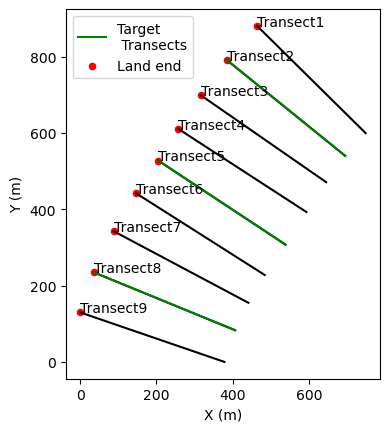

In [33]:
# Visualize transects
fig, ax = plt.subplots(1,1)

# Plot transects
ax.plot(df_tran[['Land_x', 'Sea_x']].transpose(), 
        df_tran[['Land_y', 'Sea_y']].transpose(),
        color='k')

# Plot target transects
ax.plot(df_tran.loc[target_trans, ['Land_x', 'Sea_x']].transpose(), 
        df_tran.loc[target_trans, ['Land_y', 'Sea_y']].transpose(),
        color='g')
ax.plot([], [], color='g', label='Target\n Transects')

# Highlight landward ends
df_tran.plot.scatter('Land_x', 'Land_y', c='r', 
                     label='Land end', ax=ax)


# Add transect labels
for i, row in df_tran.iterrows():
    ax.text(row['Land_x'], row['Land_y'], i)

# Set ax labels
ax.set_aspect('equal')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

ax.legend()
plt.savefig('figures/transects.jpg', dpi=300, bbox_inches='tight')

# 1.2 Check shoreline positions

Shoreline positions were retrieved from Landsat 5, 7, 8 and 9 satellite images with [CoastSat toolbox](https://github.com/kvos/CoastSat/tree/master).\
All the shorelines have been corrected to reflect the instaneous position at Mean Sea Level\
Only shorelines from 1987 to 2018 are avaiable for model training/calibration in this site.\
Along each transect, shoreline positions were provided as the distance to the **landward** end of the transect.

In [34]:
fn_obs =  'shorelines_obs.csv' # File name for shoreline observation
fn_targ_short =  'shorelines_target_short.csv' # File name for short-term shoreline prediction target
fn_targ_medium =  'shorelines_target_medium.csv' # File name for medium-term shoreline prediction target
fn_gt =  'shorelines_groundtruth.csv' #File name for groudtruth

# Read shoreline data
df_gt = pd.read_csv(os.path.join(fp, 'shorelines', fn_gt), index_col='Datetime')
df_gt.index = pd.to_datetime(df_gt.index)

df_targ_short = pd.read_csv(os.path.join(fp, 'shorelines', fn_targ_short), index_col='Datetime')
df_targ_short.index = pd.to_datetime(df_targ_short.index)

df_targ_medium = pd.read_csv(os.path.join(fp, 'shorelines', fn_targ_medium), index_col='Datetime')
df_targ_medium.index = pd.to_datetime(df_targ_medium.index)

df_obs = pd.read_csv(os.path.join(fp, 'shorelines', fn_obs), index_col='Datetime')
df_obs.index = pd.to_datetime(df_obs.index)
df_obs

,Transect1,Transect2,Transect3,Transect4,Transect5,Transect6,Transect7,Transect8,Transect9
Datetime,,,,,,,,,
1999-02-17,197.025794,192.969658,194.385116,196.570713,203.401153,207.902414,206.323159,199.502146,193.688521
1999-03-05,185.473336,186.279262,184.123460,181.000405,206.612193,198.473587,205.950591,195.028865,180.209910
1999-06-25,203.434419,198.020000,190.394388,187.103369,174.737676,175.541281,171.384529,167.083654,181.939221
1999-07-11,199.726943,203.252659,196.139268,183.378867,187.835172,183.248025,179.708851,170.776831,184.349005
1999-07-19,198.314195,192.192448,194.484527,188.295508,184.851746,181.916500,181.849139,166.181496,175.351397
...,...,...,...,...,...,...,...,...,...
2018-09-17,213.394475,208.873642,207.614407,200.922483,189.609754,197.508301,186.292343,175.528700,NaN
2018-10-19,NaN,205.638208,204.622951,195.457303,201.689672,196.422823,190.711102,184.904075,NaN
2018-11-04,204.162356,198.982894,192.175758,202.318754,199.186722,191.612484,190.450079,181.909032,185.167295


## 1.2.1 Spatial variation

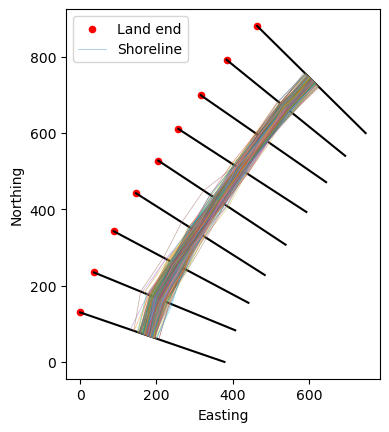

In [35]:
# Spatial view of shoreline position
land_x, land_y = df_tran['Land_x'], df_tran['Land_y'] # Land end coords
sea_x, sea_y = df_tran['Sea_x'], df_tran['Sea_y'] # Sea end coords
tran_len = np.sqrt((sea_x-land_x)**2+(sea_y-land_y)**2) # Length of transect


fig, ax = plt.subplots(1,1)

# Plot transects
ax.plot(df_tran[['Land_x', 'Sea_x']].transpose(), 
        df_tran[['Land_y', 'Sea_y']].transpose(),
        color='k')

# Plot land ends
df_tran.plot.scatter('Land_x', 'Land_y', c='r', 
                     label='Land end', ax=ax)

# Iterate dates
for date, row_obs in df_obs.iterrows():
    
    # Only label first shoreline
    if date == df_obs.index[0]:
        label_obs = 'Shoreline'
    else:
        label_obs = None
    
    # Calculate shoreline coords
    x_obs = land_x + row_obs/tran_len*(sea_x-land_x)
    y_obs = land_y + row_obs/tran_len*(sea_y-land_y)
    
    # Plot shoreline
    ax.plot(x_obs, y_obs, alpha=0.5, linewidth=0.5, label=label_obs)
        
    
    
ax.set_aspect('equal')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

ax.legend()
plt.savefig('figures/shorelines_spatial.jpg', dpi=300, bbox_inches='tight')

### 1.2.2 Temporal variation

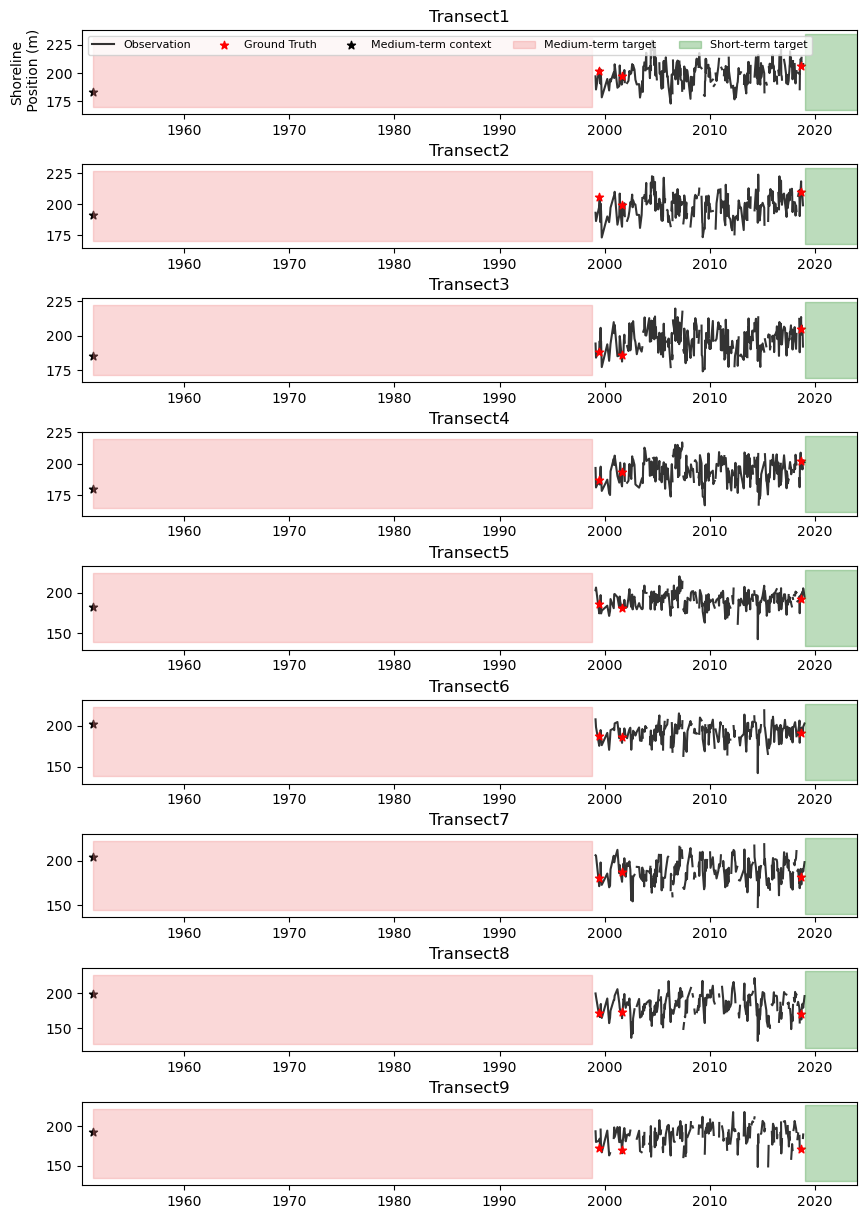

In [36]:
# Temporal view of shoreline position

fig, axes = plt.subplots(len(df_tran), 1, figsize=(10, 15))

# Iterate transects 
for i, tran_id in enumerate(df_tran.index):
    
    #ax = axes[int(i%(len(df_tran)/2)), int(i//(len(df_tran)/2))]
    ax = axes[i]
    
    # Plot time series of shoreline
    ax.plot(df_obs.index, df_obs[tran_id], color='k', label='Observation', zorder=-1, alpha=0.8)
    ax.scatter(df_gt.index, df_gt[tran_id], color='r', marker='*', 
               label='Ground Truth', zorder=1)
    ax.scatter(df_targ_medium.index, df_targ_medium[tran_id], color='k', marker='*', 
               label='Medium-term context', zorder=1)
    
    ax.fill_between(df_targ_medium.index, ax.get_ylim()[0], ax.get_ylim()[1], alpha=0.3, 
                    color='lightcoral', label='Medium-term target')
    ax.fill_between(df_targ_short.index, ax.get_ylim()[0], ax.get_ylim()[1], alpha=0.3, 
                    color='forestgreen', label='Short-term target')
    
    ax.set_title(tran_id)
    ax.set_xlim((df_targ_medium.index.min()-pd.Timedelta(days=365), df_targ_short.index.max()))
    
    if i == 0:
        ax.set_ylabel('Shoreline\n Position (m)')
        ax.legend(ncol=5, fontsize=8, loc=2)
        
fig.subplots_adjust(hspace=0.6)
plt.savefig('figures/shorelines_temporal.jpg', dpi=300, bbox_inches='tight')

# 1.3 Check Waves

Offshore wave data is from [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) wave spectra data.\
SWAN model was used to transfer offshore wave into nearshore with [Binwave](https://www.sciencedirect.com/science/article/pii/S1463500324000337) approach developed by Dr Laura Cagigal.\
Along each transect, the wave data was extracted at 10m contour 

In [37]:
# Read data

# Hs: Significant wave height
# Tp: Peak wave period
# Dir: Mean wave direction

WAVE_PARAMS = ['Hs', 'Tp', 'Dir'] 

dfs_wave = {}
for wave_param in WAVE_PARAMS:
    df_wave = pd.read_csv(
        os.path.join(fp, 'hindcast_waves' ,'{}.csv'.format(wave_param)),
        index_col = 'Datetime'
    )
    df_wave.index = pd.to_datetime(df_wave.index)
    dfs_wave[wave_param] = df_wave
    


# 1.3.1 Check wave roses for different transects

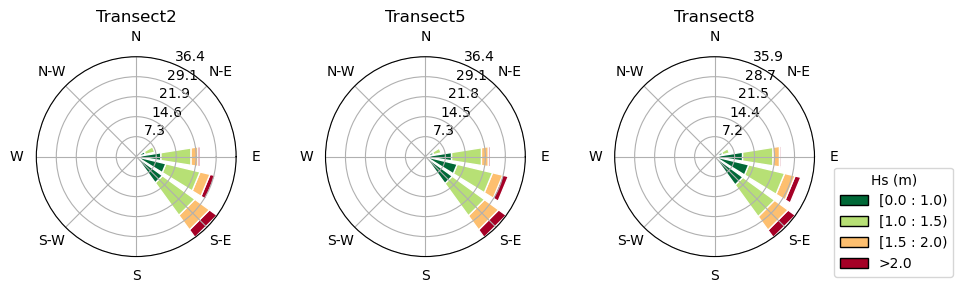

In [38]:
# Plot wave roses

fig, axes = plt.subplots(ncols=3, figsize=(10, 3),
                        subplot_kw={'projection': 'windrose'})

for i, tran_id in enumerate(target_trans):
    ax = axes[i]
    
    # Plot wave rose for Hs
    ax.bar(dfs_wave['Dir'][tran_id], dfs_wave['Hs'][tran_id], normed=True, opening=0.8, bins=[0, 1, 1.5, 2], 
        cmap=cm.RdYlGn_r, edgecolor='white')
    ax.set_title(tran_id)

    if i == 2:
        cbar = ax.legend(loc=(1.1, -0.1), title='Hs (m)')

plt.tight_layout()
plt.savefig('figures/wave_roses.jpg', dpi=300, bbox_inches='tight')

# 1.3.2 Check time series of wave parameters (Average across transects)

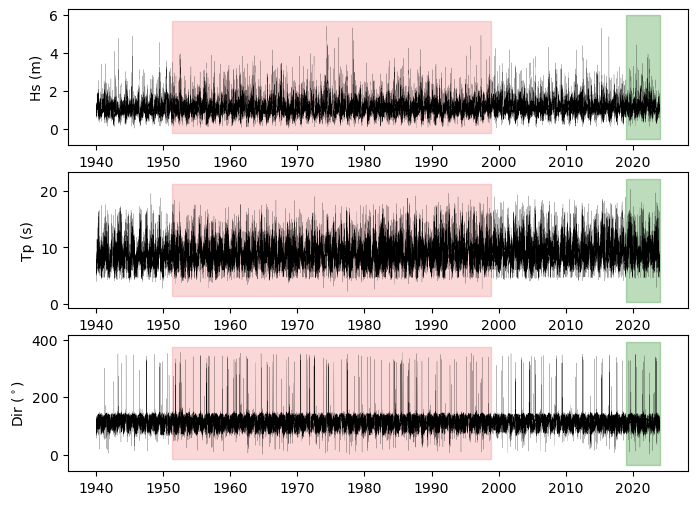

In [39]:
# Plot timeseries wave parameters averaged over transects
tran_id = 'Transect1'
labels = ['Hs (m)', 'Tp (s)', 'Dir ($^\circ$)']

fig, axes = plt.subplots(3, 1, figsize=(8, 6))

for i, wave_param in enumerate(WAVE_PARAMS):
    # Calculate the average 
    df_mean = dfs_wave[wave_param].mean(1)
    ax = axes[i]
    ax.plot(df_mean.index, df_mean.values, color='k', linewidth=0.1)
    ax.fill_between(df_targ_medium.index, ax.get_ylim()[0], ax.get_ylim()[1], alpha=0.3, 
                    color='lightcoral', label='Medium-term target')
    ax.fill_between(df_targ_short.index, ax.get_ylim()[0], ax.get_ylim()[1], alpha=0.3, 
                    color='forestgreen', label='Short-term target')
    ax.set_ylabel(labels[i])
plt.savefig('figures/wave_ts.jpg', dpi=300, bbox_inches='tight')    

# 1.3 Check Sea level rise

In [40]:
# Read data

df_SLR_obs = pd.read_csv(
    os.path.join(fp, 'sealevel', 'SLR_obs.csv'),
    index_col = 'Year')
df_SLR_proj = pd.read_csv(
    os.path.join(fp, 'sealevel', 'SLR_proj.csv'),
    index_col = 'Year')

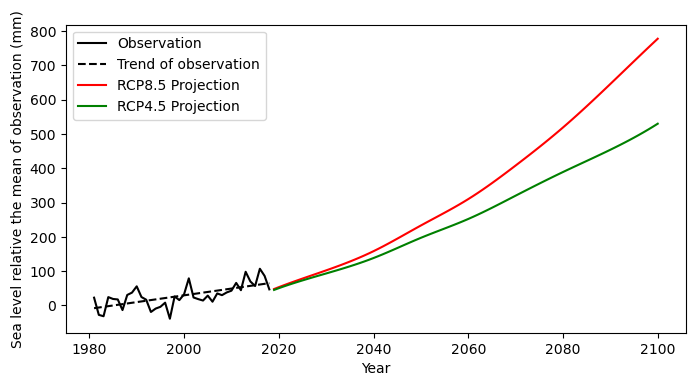

In [41]:
# Plot time series
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# ax.hlines(df_SLR_obs['SLR (mm)'].mean(), df_SLR_obs.index[0], df_SLR_obs.index[-1], 
#           color='r', linestyle='--', label='baseline (Mean of observation)')
a, b = np.polyfit(df_SLR_obs.index, df_SLR_obs['SLR (mm)'], 1)
ax.plot(df_SLR_obs.index, df_SLR_obs['SLR (mm)'], color='k', linestyle='-', label='Observation')
ax.plot(df_SLR_obs.index, a*df_SLR_obs.index+b, color='k', linestyle='--', label='Trend of observation')
ax.plot(df_SLR_proj.index, df_SLR_proj['RCP85'], color='r', linestyle='-', label='RCP8.5 Projection')
ax.plot(df_SLR_proj.index, df_SLR_proj['RCP45'], color='g', linestyle='-', label='RCP4.5 Projection')

ax.set_xlabel('Year')
ax.set_ylabel('Sea level relative the mean of observation (mm)')

plt.legend()
plt.savefig('figures/SLR_ts.jpg', dpi=300, bbox_inches='tight') 